In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import shutil # For saving/loading model

torch.manual_seed(0) # For reproducability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_cuda = torch.cuda.is_available()
if use_cuda:
  print('GPU connected')

# Fast Neural Style Transfer 


<img align="left" src="Data/cornell-starry-night.png" width="200"/>
<img align="left" src="Data/cornell-scream.png" width="200" hspace="200"/>


This is an implementation of the neural style transfer method described in [Perceptual Losses for Real-Time Style Transfer and Super Resolution](https://arxiv.org/abs/1603.08155) by Justin Johnson, Alexandre Alahi, and Li Fei-Fei. When I first heard about neural style transfer and the [classic paper](https://arxiv.org/abs/1508.06576) by Gatys et al, I was excited until I realized how slow the algorithm was at run time. I knew there must be a way to do it faster and stumbled upon this paper and decided it would be fun to implement it. As a note, I've changed somethings from the original implementation based on later research. I'll point them out as we go.

## Image Transformation Network
Let's build the image transformation network. As described in the paper, this network learns to transform a content image to a specific style. A different network must be trained for different styles. The architecture is described in the paper and more explicitly in the [supplementary materials](https://cs.stanford.edu/people/jcjohns/papers/fast-style/fast-style-supp.pdf). The dimensions didn't quite produce the expected output dimension with valid padding on some layers, they were off by one(e.g. expected (256, 256, 32) and got (255, 255, 32)). Hence the uneven padding.

The image transformation network differs slightly from the one in the paper. I replaced the transposed convolution layers with upsample-convolution blocks based on the paper [Deconvolution and Checkerboard Artifacts](https://distill.pub/2016/deconv-checkerboard/) which showed that these blocks helped reduce the checkerboard artifacting that is common with regular transposed convolutions. Additionaly, based on the paper [Instance Normalization: The Missing Ingredient for Fast Stylization](https://arxiv.org/abs/1607.08022), I chose to use instance normalization instead of batch normalization.

In [8]:
# Residual block, as defined in the paper
class ResBlock(nn.Module):
    
    def __init__(self, channels_in = 128, kernel_size=3, filters=[128, 128]):
        super(ResBlock, self).__init__()
        f1, f2 = filters
        self.conv1 = nn.Conv2d(channels_in, f1, kernel_size, padding=int((kernel_size-1)/2))
        self.norm1 = nn.InstanceNorm2d(f1)
        self.conv2 = nn.Conv2d(f1, f2, kernel_size, padding=int((kernel_size-1)/2))
        self.norm2 = nn.InstanceNorm2d(f2)
        
    def forward(self, x):
        x_input = x
        x = self.conv1(x)
        x = F.relu(self.norm1(x))
        x = self.conv2(x)
        return self.norm2(x) + x_input

resb = ResBlock()

In [9]:
# Upsample --> Convolution blocks to replace transposed convolution
class UpsampleConv(nn.Module):
  
  def __init__(self, size, in_channels, out_channels, mode='nearest'):
    super(UpsampleConv, self).__init__()
    self.upsample = nn.Upsample(size=size, mode=mode)
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
    
  def forward(self, x):
    x = self.upsample(x)
    x = self.conv(x)
    return x

In [10]:
class ImageTransNet(nn.Module):
    
    def __init__(self):
        # Takes in an RGB image, in training this image will be 256 x 256
        super(ImageTransNet, self).__init__()
        self.pad = nn.ZeroPad2d((1,0,1,0))
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=9, stride=1, padding=4)
        self.norm32 = nn.InstanceNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0)
        self.norm64 = nn.InstanceNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0)
        self.norm128 = nn.InstanceNorm2d(128)
        
        self.res1 = ResBlock()
        self.res2 = ResBlock()
        self.res3 = ResBlock()
        self.res4 = ResBlock()
        self.res5 = ResBlock()
        
        self.upsample_conv1 = UpsampleConv((128, 128), 128, 64, mode='nearest')
        self.upsample_conv2 = UpsampleConv((256, 256), 64, 32, mode='nearest')
        
        self.conv4 = nn.Conv2d(32, 3, kernel_size=9, stride=1, padding=4)
        self.norm3 = nn.InstanceNorm2d(3)
    
    def forward(self, x_in):
        x = self.conv1(x_in)
        x = F.relu(self.norm32(x))
        
        x = self.pad(x)
        x = self.conv2(x)
        x = F.relu(self.norm64(x))
        
        x = self.pad(x)
        x = self.conv3(x)
        x = F.relu(self.norm128(x))
        
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.res5(x)

        x = self.upsample_conv1(x)
        x = F.relu(self.norm64(x))

        x = self.upsample_conv2(x)
        x = F.relu(self.norm32(x))

        x = self.conv4(x)
        x = F.relu(self.norm3(x))
        
        return x


## Pretrained Model
Now we need to import a pretrained model to use to identify features in our images which can then be used in a custom loss function. In this case, the pretrained model is VGG-16. A custom model is built using VGG-16 to output the specific layer activations needed for the loss function

In [11]:
# Load vgg-16 
# Code from:
# https://discuss.pytorch.org/t/accessing-intermediate-layers-of-a-pretrained-network-forward/12113/2
# Rewrite someday(rewrite solely for originality, code works perfectly well so no rush)
class VGG_truncated(nn.Module):
    
    def __init__(self):
        super(VGG_truncated, self).__init__()
        features = list(torchvision.models.vgg16(pretrained=True).features)[:23] # Last layer is layer 22, need nothing else
        self.layers = nn.ModuleList(features).eval()
    
    def forward(self, x):
        activations = []
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i in {3, 8, 15, 22}: # relu1_2, relu2_2, relu3_3, and relu 4_3 respectively
                activations.append(x) # actvation at this layer
        return activations

vgg = VGG_truncated()
if use_cuda:
    vgg = vgg.cuda()
for param in vgg.parameters(): # Freeze
    param.requires_grad_(False)

## Loss Function
The model's loss function is a combination of the feature loss and the style loss as well as some regularization. 

The feature loss compares the normalized Euclidian distance between the predicted image and the content image on layer `relu2_2` in VGG-16.

The style loss is more complicated. First the input tensor of shape (C, H, W) is reshaped to (C, H x W) where C is the number of channels, H the height, and W the width. This matrix is multiplied by its transpose and divided by C x H x W to normalize it. This is the Gram matrix for the input tensor. The style loss is the squared norm of the difference of the Gram matrix for the style image and of the Gram matrix for the predicted image. The style loss is generated for layers `relu1_2`, `relu2_2`, `relu3_3`, and `relu4_3` of VGG-16.

The total variation regularizer encourages nearby pixels to be similar to each other.

The model loss is the sum of the feature loss, the style loss, and the regularization. The weight given to each can be adjusted and by default gives all losses equal weight.

In [12]:
def feature_loss(gen, content): #averaged loss over all samples in the batch
    n, C, H, W = content.shape
    loss = 0
    for i in range(n):
        loss += 1/(C*H*W) * (torch.norm(gen[i] - content[i]) ** 2)
    return loss/n

In [13]:
def gram_mat(x):
    C, H, W = x.shape
    x = x.view(C, H*W)
    return 1/(C*H*W) * torch.mm(x, torch.t(x))

In [14]:
def style_loss(gen, style):
    style_mat = gram_mat(torch.squeeze(style)) # get rid of batch dimension
    n, C, H, W = gen.shape
    
    loss = 0
    for i in range(n):
        gen_mat = gram_mat(gen[i])
        loss += torch.norm(gen_mat - style_mat, p='fro') ** 2
    return loss/n

In [15]:
def model_loss(gen, content, reg_fact=1e-4, content_fact=1, style_fact=[1e3]*4):
    reg_factor = reg_fact
    content_factor = content_fact
    style_factor = style_fact
    
    gen_activations = vgg(gen)
    content_activations = vgg(content)
    
    loss = content_factor * feature_loss(gen_activations[1], content_activations[1]) # activations @ relu2_2
    
    for i, gen_activ in enumerate(gen_activations):
        loss += style_factor[i] * style_loss(gen_activ, style_activations[i])

    # Regularization
    loss += reg_factor * (torch.sum(torch.abs(gen[:, :, :, 1:] - gen[:, :, :, :-1]))
                          + torch.sum(torch.abs(gen[:, :, 1:, :] - gen[:, :, :-1, :])))
    
    loss *= 1e4
    #print('loss:', loss.item())
    return loss

## Style
Let's pick our style image! There are few available in `Data` like `starry-night.jpg`, `scream.jpg`, and `waves.jpg`. For the Gatys et al implementation of NST, we can change our style image freely. For the fast NST, we are locked in to one style image per trained model.

In [17]:
def get_img(path='Data/starry-night.jpg'):
    img = Image.open(path)
    img = img.resize((256, 256))
    plt.imshow(img)
    img = transforms.ToTensor()(img)
    img = torch.unsqueeze(img, 0)
    return img

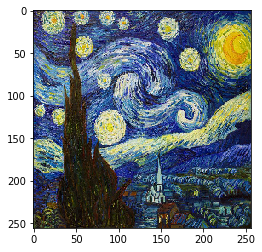

In [104]:
style = get_img(path='Data/starry-night.jpg')
if use_cuda:
    style = style.cuda()
style_activations = vgg(style)

## Slow NST
As an aside to check that our loss function is correct, we can run the Gatys neural style transfer which is much slower, although more flexible in terms of changing style images. It produces quite nice outputs.

![](Data/style-transfer.png)

In [ ]:
# Gatys et al style

content = get_img('Data/cornell.jpg')
prediction = torch.autograd.variable(torch.randn(1, 3, 256, 256), requires_grad=True, device=device)
if torch.cuda.is_available():
    content = content.cuda()
optim = torch.optim.LBFGS([prediction], lr=1)

iteration = 0
def closure():
    global iteration
    optim.zero_grad()
    loss = model_loss(prediction, content, reg_fact=1e-5, content_fact=1e1, style_fact=[1e3]*4) #change to e3/e4, maybe reduct lr
    loss.backward(retain_graph=True)
    
    if iter % 10 == 0:
            print('Iteration:', iteration, 'Loss', loss.item())
            if torch.cuda.is_available():
                plt.imshow(transforms.ToPILImage()(prediction[0].cpu().detach()))
            else:
                plt.imshow(transforms.ToPILImage()(prediction[0]))
            plt.show()
    iteration += 1
    return loss

for round in range(100): # 20 iterations per round, 100 rounds = 2000 iterations total
    print('Round:', round)
    optim.step(closure)

prediction = torch.clamp(prediction, 0, 255)
if torch.cuda.is_available():
    plt.imshow(transforms.ToPILImage()(prediction[0].cpu().detach()))
else:
    plt.imshow(transforms.ToPILImage()(prediction[0]))

## Data
Almost there! Now it's time to import the data needed. For training, we use the mscoco dataset(FAR too large to be contained in memory, at least on a college student's computer), so the DataLoader comes in handy here to load images in small batches. Also note that a single style image was selected and imported for training the model on. Recall that the neural style transfer model only transfers one specific style and, although the same framework will work, multiple models must be trained for applying multiple different styles.

In [87]:
# LOAD THE DATA !
preprocess = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
mscoco = torchvision.datasets.ImageFolder('Data/mscoco/train2014', transform=preprocess)

In [97]:
data_loader = torch.utils.data.DataLoader(mscoco, batch_size=4)

## Training
Time to train the model! Following the original implementation, it is trained with two passes over mscoco. The optimizer is Adam with learning rate `0.001`. I chose the style and content factors based on my own tests, roughly in line with what Gatys et al reccomended in their original paper. As reccomended, I kept the regularization strength between `1e-3` and `1e-5`.

In [23]:
net = ImageTransNet()
if use_cuda:
    net = net.cuda()
    
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
        
net.apply(init_weights)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
start_epoch = 0

In [ ]:
# Train model
for epoch in range(start_epoch, 2):
    
    for batch_index, data in enumerate(data_loader):
        data = data[0] # data[1] is the 'class', which is always 0, just want the tensors
        if use_cuda:
            data = data.cuda()
        inputs = data
        content = data

        # Zero gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = model_loss(outputs, content, reg_fact=1e-3, content_fact=5e1, style_fact=[1e3]*4)
        loss.backward()
        optimizer.step()

        # Occasionally show image
        if batch_index % 10 == 0: 
            print('Image:', 1+4*batch_index, 'Loss:', loss.item())
            if use_cuda:
                plt.imshow(transforms.ToPILImage()(torchvision.utils.make_grid([data[0].cpu().detach(), outputs[0].cpu().detach()], nrow=2)))
            else:
                plt.imshow(transforms.ToPILImage()(torchvision.utils.make_grid([data[0].detach(), outputs[0].detach()], nrow=2)))
            plt.show()
        
        del loss # Might not help, but can't hurt to free up some memory
        
    save_checkpoint({
              'epoch': epoch + 1,
              'state_dict': net.state_dict(),
              'optimizer' : optimizer.state_dict(),
          }, True)
    print('Epoch:', epoch+1, '\n\nSAVED A NEW CHECKPOINT\n\n')

## Results
As you can see, the results aren't bad! There is some artifacting around the edges, but that can be mitigated by padding your image with zeroes and then cropping afterwards. Part of the reason this artifacting is occuring is because I chose to pad with zeroes. After having trained the model, I realized reflection padding would help mitigate this significantly. Unfortunately retraining the model is pretty expensive so I'm leaving starry night like this and training a scream model with reflection padding. Overall, I'm pretty happy with the results

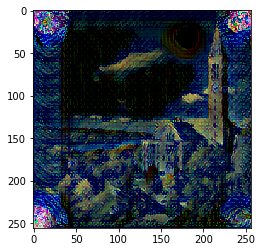

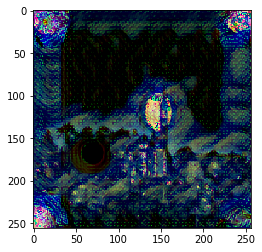

In [27]:
content1 = get_img('Data/cornell.jpg')
model = torch.load('starry_night.pth.tar', map_location=device)
net.load_state_dict(model['state_dict'])
pred1 = net(content1)
plt.imshow(transforms.ToPILImage()(pred1[0]))
plt.show()

content2 = get_img('Data/cornell-night.jpg')
pred2 = net(content2)
plt.imshow(transforms.ToPILImage()(pred2[0]))
plt.show()